# COGS 118B - Final Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from scipy import stats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Unlocking Fantasy Football: An Unsupervised Learning Analysis

## Group members

- Christopher Tams
- Vi Phan
- Dayoung Ki
- Eric Dong

# Abstract 
Our project aims to develop a K-Means algorithm that helps predict standout performers in the upcoming NFL season, using a combination of biological features and previous performance statistics. Using multiple algorithms based on player position, we create clusters that groups players based on their respective statistics. The model performance is then measured and assessed using measures such as the silhouette score, which ensures clear clustering quality based on the data. The data used is pulled from a variety of sources: NFL team statistics from  2003-2023, individual player stats and features, and individual player performance from Pro-Football Reference. The analysis reveals that the K-Means algorithm combined with UMAP for dimensionality reduction was the most effective model for our dataset. The K-Means algorithm with a cluster count of 4 was the best way to visualize the data and get an optimal silhouette score. Despite various limitations in the dataset, the models themself, and the hyperparameters we were using, the clusters still accommodate and count for the similarity between different players in the NFL, aiding fantasy draft decisions. Thus, this model is good for providing insights into player performance levels as players seek after ideal draft pick performances, while keeping limitations in mind. 

# Background

American football is one of the world's most popular sports, with millions of fans tuning in to see their favorite players compete in an exciting game. The National Football League, or NFL, as it is more widely known, is the most well-known American football league. The NFL season culminates with the annual Super Bowl, which attracts a large audience every year<a name="operationnote"></a>[<sup>1</sup>](#operation). While the players on the field may be the only ones throwing or catching the ball, they are not the only ones participating in a game. As fans watch the action on the field, another form of engagement has emerged: fantasy football. Fantasy football allows football fans to create virtual teams, draft real NFL players, and compete using performance statistics. As the 2023 season has now concluded, fans are frantically analyzing player statistics to determine which players would be the best to draft for their 2024 fantasy football teams. This project aims to help fantasy football fans determine their draft picks by grouping players with similar stats. The use of AI to help fans with their fantasy football leagues is not a novel concept. Gridiron AI, a popular app, uses data analysis to help users make the best draft picks<a name="NFLAInote"></a>[<sup>2</sup>](#NFLAI). However, unlike Gridiron AI, our project will take a more diverse approach by investigating a different statistical model and will not be locked behind a paywall. 

# Problem Statement

The objective of this project is to develop a K-means algorithm to predict the potential standout performers for the upcoming NFL season. The datasets we will be using for this project utilize biological features and past performance statistics of the players. This dataset will be segmented into subsets based on their positions, and K-means algorithms will be training each subset to create clusters, grouping players according to their statistics. We will generate random clusters of players based on their attributes to evaluate the performance of the K-means. We will also apply the silhouette score to determine if it is able to accurately cluster players based on their attributes. The silhouette score shows how well separated the clusters are–scores closer to 1 indicates better separation. Lastly, because this process can be iterative in different NFL seasons using the similar datasets and method, this is replicable.

# Data

There is a lot of big data revolving around the NFL, so finding relevant data wasn’t hard. Although there was a lot of places to choose from, we ended up narrowing down to three data sources: 

**NFL Team Data 2003-2023**<a name="Cantalupanote"></a>[<sup>3</sup>](#Cantalupa):
This data set consists of 35 variables and 320 observations. The variables revolve around the overall yearly performance of each individual NFL team for the past 20 years. These describe features like number of wins/losses, the number of touchdowns, and average yards per play. All of the variables besides team name and year are quantitative variables that are describing either the total number of something happening (like wins and losses) or the average number of something gained/lost(like rushing yards per attempt). Because of this all of the observations, besides the name of the team, are represented by an int or float. The data is as clean as it is, so there wasn’t a need to do any special handling/cleaning. 


**NFL Player Statistic dataset**<a name="Steussienote"></a>[<sup>4</sup>](#Steussie):
This data set is a lot bigger than the others and is divided into many different parts. We chose to focus primarily on the combine portion of the dataset. This data revolves around each individual player's biological features and athletic capabilities. The data set has 35 variables and 9814 observations. Each observation has a mix of int, floats, and strings. The variables that have strings consist of either the name of the player, name of team, name of college, position of the player, or name of home city. The other variables consist of measurements in inches(like arm length), pounds(like weight or bench press), and seconds(like 40 meter dash). The data already came really clean so there was not much that we needed to adjust. 


**Pro-Football Reference**<a name="profootballnote"></a>[<sup>5</sup>](#profootball):
Pro-Football Reference holds a lot of statistical data from NFL player performance throughout the many decades of the NFL. To collect this data, we decided to Web Scrape using pandas built in function pd.read_html(url). This allowed us to seamlessly collect NFL data for individual players ranging from the years 2003-2022. The url for the different positions and years are very predictable so using a simple for loop that changed the url each time to reflect the year and position of players we were looking for was simple.


Once we got all of the data, we Concated them into three different data frames, named passing, rushing, and receiving. The dimensions of these data frames were (1475, 31), (2671, 15), and (4020, 19) respectively.

We then added all of the teams and combined data to each NFL player's respective row. After incorporating the combine data 30%, 43%, and 51% of players had been dropped from the passing, rushing, and receiving data frames due to insufficient data from the combine. We didn't have to drop any players after incorporating the team data. 

We then went through the columns of the passing, rushing, and receiving to take out unnecessary data like "High School Name". After, we went through the columns again to drop those who had more than 5% of their values NaN. Those who had less than 5% NaN but more than 0% had their NaN replaced with the average of the column. 

We then Web Scraped from Pro-Football Reference one more time to get each NFL player's Fantasy Football Rankings and insert them into their respective rows in the passing, rushing, and receiving dataframes. After, we generalize their position to being in top 10, 20, 30, etc. For example a QB that is 5th rank is in the top 10 while a QB that is 15th rank is in the top 20. We put this into a column called Next_Year_PosRank and we will later use that to see how well the clusters separated the different talents. 

Finally, we normalized all of the columns using Z-score normalization and exported the dataframes as Cleaned_Passing, Cleaned_Rushing, and Cleaned_Receiving. The final dimensions for these data frames were (1173, 66), (1692, 54), (2296, 57) respectively.


In [2]:
Passing = pd.read_csv('Data_Wrangle/data/Cleaned_Passing.csv')
Rushing = pd.read_csv('Data_Wrangle/data/Cleaned_Rushing.csv')
Receiving = pd.read_csv('Data_Wrangle/data/Cleaned_Receiving.csv')

# Proposed Solution

One potential solution to the problem of assisting fantasy football fans in making draft picks is to use a clustering algorithm to group players with similar stats. We wanted to specifically focus on using the K-means algorithm using each player’s statistical profile that can be inputted into the algorithm. We can use Python’s scikit-learn library to perform the K-means clustering. After the clusters are created, fantasy football fans can use the clusters to create their draft picks. For example, if two players are in the same cluster, it indicates that they have similar statistical profiles and may be interchangeable in fantasy value. If a player is selected, team owners can use the clusters to look for players who are statistically similar to the first player. We intended to evaluate our model's accuracy by looking at the silhouette score.

# Evaluation Metrics

Given that we wanted to cluster our dataset using the K-means algorithm to look at the different statistics of Football players of the 2023 NFL season, the evaluation metric we wanted to focus on was assessing the cluster qualities we have and see how well the algorithm fits our data in proper clusters. In addition, we wanted to focus on being able to interpret the results well given the different clusters. 

One of the evaluation metrics we wanted to focus on is the silhouette score, which measures the similarity of data points within the clusters compared to the data points in the neighboring clusters. Specifically, the silhouette score is calculated as S = (b-a) / (max(a,b)) where ‘a’ is the average distance between a data point to all other data points within the same cluster and ‘b’ is the average distance between a data point to all data points in the nearest neighboring cluster. A silhouette score of 0 indicates that the data point is close to the decision boundary between the two neighboring clusters. As the score is closer to +1, the data point is well matched to its own cluster while closer to -1 means that the data point may have been assigned to the wrong cluster. Initially, we were thinking of using adjusted rand score as an evaluation metric; however, we didn't have ground truth labels as there is no set cluster these football players belong to; thus, the silhouette score was a good alternative as it gives a measurement of how well the clusters are separated.


Another evaluation metric we wanted to look at was the Elbow graphing method as well, a way to find the optimal K value for our K-means algorithm. This method graphs the Within-Cluster Sum of Squares, which really just gets the sum of the square distances between the points in the cluster and the cluster center. Then, we can look at the graph and see where the WCSS value starts to flatten out as the number of clusters increases. 

# Results

What we are aiming to do throughout this entire report is create an algorithm to group players based on statistical similarity, which will enable insightful analysis for team management and strategic decision-making in American football.

### K-Means Feature Selection

During the feature selection phase of our clustering task using football statistics datasets, we organized and extracted performance metrics related to football players' passing, running, and receiving skills. Based on our knowledge of football dynamics, we selected a wide range of statistics that together represent the complex skill sets displayed on the field. These metrics range from basic passing accuracy to complex running and receiving proficiency measures. We aim to create informative clusters that represent the diverse roles and contributions of players in different aspects of the game by choosing features that capture different facets of player performance. This feature selection procedure serves as the foundation for our next use of the KMeans algorithm.


In [3]:
passing_features = Passing[['Cmp', 'Att','Cmp%','Yds','TD','Int','Y/A']]
receiving_features = Receiving[['Tgt','Rec','Yds','TD','Succ%','R/G','Y/G']]
rushing_features = Rushing[['Att','Yds','TD','1D','Succ%','Y/A','Y/G']]

We should also determine what k value is the most appropriate for our data. To do this, we used the elbow method.

Text(0.5, 1.0, 'Distortion Measures of Passing Features')

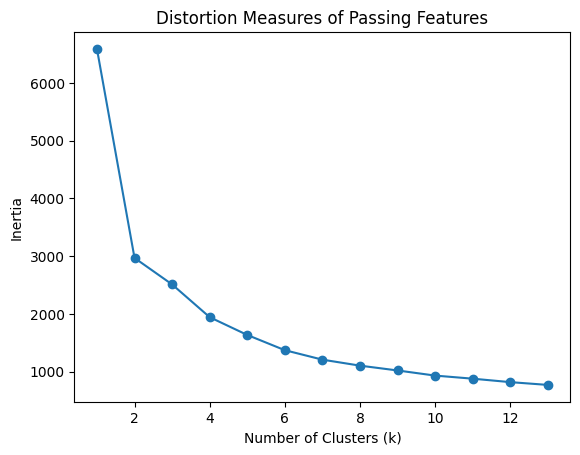

In [4]:
# Passing Features

k_values = range(1, 14)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 'auto')
    kmeans.fit(passing_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Distortion Measures of Passing Features')

Text(0.5, 1.0, 'Distortion Measures of Receiving Features')

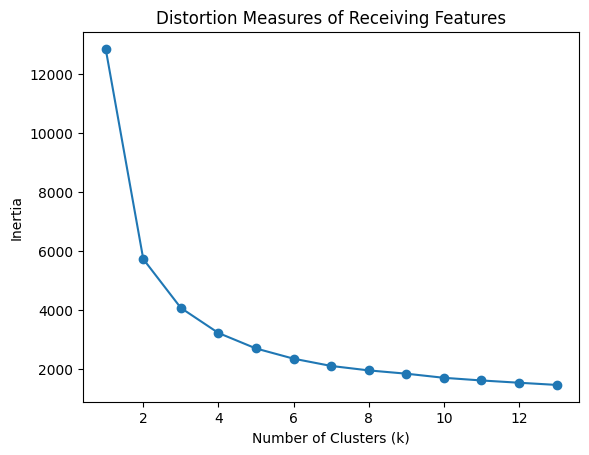

In [5]:
# Receiving Features

k_values = range(1, 14)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 'auto')
    kmeans.fit(receiving_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Distortion Measures of Receiving Features')

Text(0.5, 1.0, 'Distortion Measures of Rushing Features')

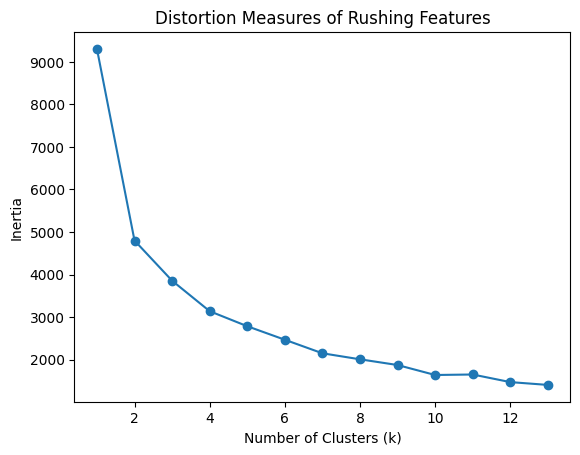

In [6]:
# Rushing Features

k_values = range(1, 14)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 'auto')
    kmeans.fit(rushing_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Distortion Measures of Rushing Features')

As we can see from the plot, according to our dataset and the elbow method where the graph starts to level off, the optimal number of clusters for all 3 datasets seem to be around 5. 

In [7]:
optimal_k = 5

### Why A K-means algorithm?

Because of the K-means algorithm's ease of use, scalability, and interpretability, we decided to use it in our project to group football players according to statistical similarity. Because K-means is easy to implement and computationally efficient, it provides an effective way to organize large datasets of player statistics. It is especially useful for analyzing various player performance metrics due to its flexibility in determining the ideal number of clusters and suitability for numerical data. K-means is a practical and effective option for our project's clustering objectives, despite its limitations, which include sensitivity to initial centroids and spherical cluster bias. At the end of our K-means modelling, we used PCA to visualize our dataset and their respective clusters.

In [8]:
kmeans_passing = KMeans(n_clusters=optimal_k, n_init='auto')
kmeans_receiving = KMeans(n_clusters=optimal_k, n_init='auto')
kmeans_rushing = KMeans(n_clusters=optimal_k, n_init='auto')

kmeans_passing.fit(passing_features.values)
kmeans_receiving.fit(receiving_features.values)
kmeans_rushing.fit(rushing_features.values)

KMeans(n_clusters=5, n_init='auto')

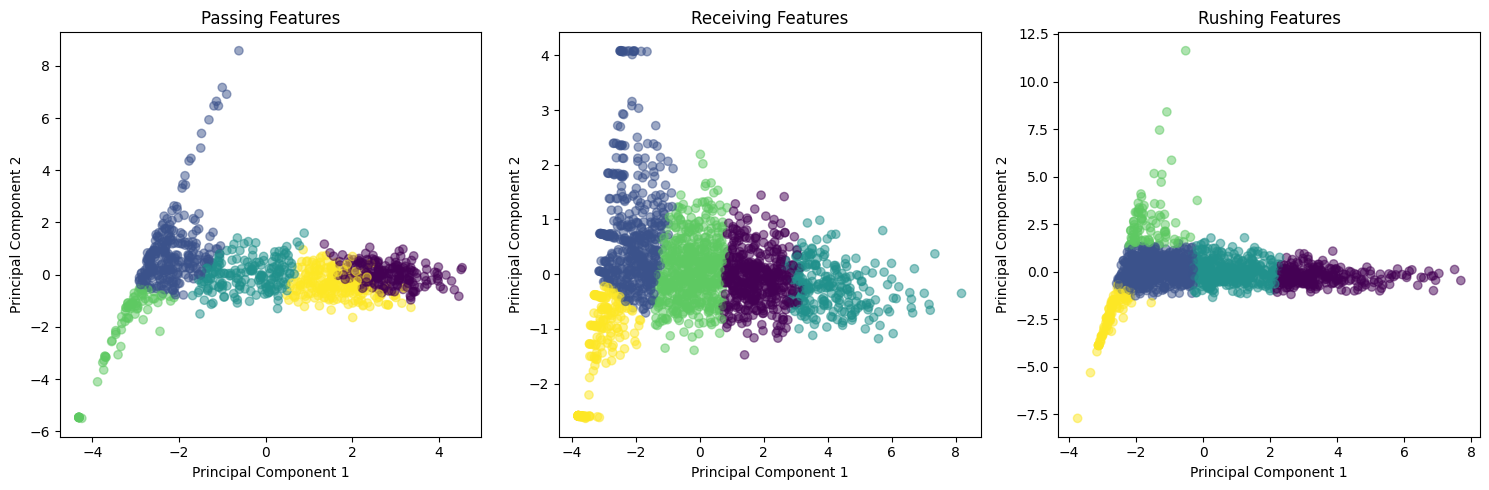

In [9]:
pca = PCA(n_components=2)
passing_pca = pca.fit_transform(passing_features)
receiving_pca = pca.fit_transform(receiving_features)
rushing_pca = pca.fit_transform(rushing_features)
plt.figure(figsize=(15, 5))

# Plot for passing dataset
plt.subplot(1, 3, 1)
plt.scatter(passing_pca[:, 0], passing_pca[:, 1], c=kmeans_passing.labels_, cmap='viridis', alpha=0.5)
plt.title('Passing Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


# Plot for receiving dataset
plt.subplot(1, 3, 2)
plt.scatter(receiving_pca[:, 0], receiving_pca[:, 1], c=kmeans_receiving.labels_, cmap='viridis', alpha=0.5)

plt.title('Receiving Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot for rushing dataset
plt.subplot(1, 3, 3)
plt.scatter(rushing_pca[:, 0], rushing_pca[:, 1], c=kmeans_rushing.labels_, cmap='viridis', alpha=0.5)
plt.title('Rushing Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

### Evaluating our K-Means Model: Sihlouette Score

In order to evaluate our results from the Kmeans algorithm, we used a Sihloutte Score. A Silhouette Score would allow us to see how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [10]:
passing_silhouette_avg = silhouette_score(passing_features, kmeans_passing.labels_)
print("Passing Silhouette Score:", passing_silhouette_avg)

receiving_silhouette_avg = silhouette_score(receiving_features, kmeans_receiving.labels_)
print("Receiving Silhouette Score:", receiving_silhouette_avg)

rushing_silhouette_avg = silhouette_score(rushing_features, kmeans_rushing.labels_)
print("Rushing Silhouette Score:", rushing_silhouette_avg)

Passing Silhouette Score: 0.26596931923365497
Receiving Silhouette Score: 0.3019361662398648
Rushing Silhouette Score: 0.32367110566300217


As we can see from the results of our Silhouette scores, our KMeans clusters have similar silhouette scores, but none are too low or high. This suggests cohesive structures and clusters, but nothing very strong.
For Passing, the clusters formed by applying KMeans to the passing features have a Silhouette Score of approximately 0.266. For Receiving, we received a score of 0.302. Finally, for Rushing the score is 0.324.

### Re-Evalulating our Model

Despite K-means being so easy to use and computationally efficient, we see that K-means alone does not do an amazing job of clustering our data, especially as our data doesn't fit well into spherical clusters. In this case, the limitations of K-means seem to outweigh the benefits. Thus, we wanted to take a look at another option to model our data and look for a way to cluster the players in groups that will make it clear how desirable they might be for fantasy football. 

### UMAP

Uniform Manifold Approximation and Projection (UMAP) is known for its unique ability to capture both local and global structure in high-dimensional data. This aligns with our clustering data using football statistics dataset. Due to the complexity of player perfomance metrics, it may exihibit non-linear patterns that can't be adequately represented in a high-dimensional space. We'll start with applying UMAP for dimensionality reduction. We also included a table that would show what percentile of players were in which cluster. This will help us determine which cluster represents which player group.

In [11]:
def UMAP_Vis(df):
    # UMAP
    columns_for_umap = [col for col in df.columns if col not in ['Player', 'Year', 'Tm']]

    data_for_umap = df[columns_for_umap]

    scaler = StandardScaler()
    data_for_umap_scaled = scaler.fit_transform(data_for_umap)

    umap_result = umap.UMAP(n_components=3, random_state=35, n_jobs=1).fit_transform(data_for_umap_scaled)

    umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])

    umap_df[['Player', 'Year']] = df[['Player', 'Year']]

    umap_df['Tm'] = df['Tm']
                       
    umap_df['Next_Year_PosRank'] = df['Next_Year_PosRank']

    # Fit K-means clustering model
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    kmeans.fit(umap_result)

    cluster_labels = kmeans.predict(umap_result)

    cluster_cmap = ListedColormap(['r', 'g', 'b', 'c', 'm'])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], umap_df['UMAP3'], c=cluster_labels, cmap=cluster_cmap, marker='o')

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')
    ax.set_title('UMAP Visualization with K-means Clusters')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster')

    plt.show()
    
    # Concatenate cluster labels with Next_Year_PosRank
    umap_df['Cluster'] = cluster_labels

    # Group data by Cluster and Next_Year_PosRank, and count occurrences
    cluster_info = umap_df.groupby(['Cluster', 'Next_Year_PosRank']).size().reset_index(name='Count')

    cluster_info["Total_Count"] = 0
    cluster_info["Percentage"] = 0
    for rank in range(9):
        rank += 1
        rank *= 10

        total = cluster_info[cluster_info["Next_Year_PosRank"] == rank]["Count"].sum()

        cluster_info.loc[cluster_info["Next_Year_PosRank"] == rank, ["Total_Count"]] = total

        for cluster in range(max(cluster_info["Cluster"]) + 1):
            count = cluster_info[(cluster_info["Next_Year_PosRank"] == rank) & (cluster_info["Cluster"] == cluster)]["Count"]
            percent_val = pd.Int64Dtype().type(100 * count / total)
            cluster_info.loc[(cluster_info["Next_Year_PosRank"] == rank) & (cluster_info["Cluster"] == cluster), ["Percentage"]] = percent_val
            
    print(cluster_info)
    
    silhouette_avg = silhouette_score(data_for_umap, cluster_labels)
    print("Silhouette Score:", silhouette_avg)


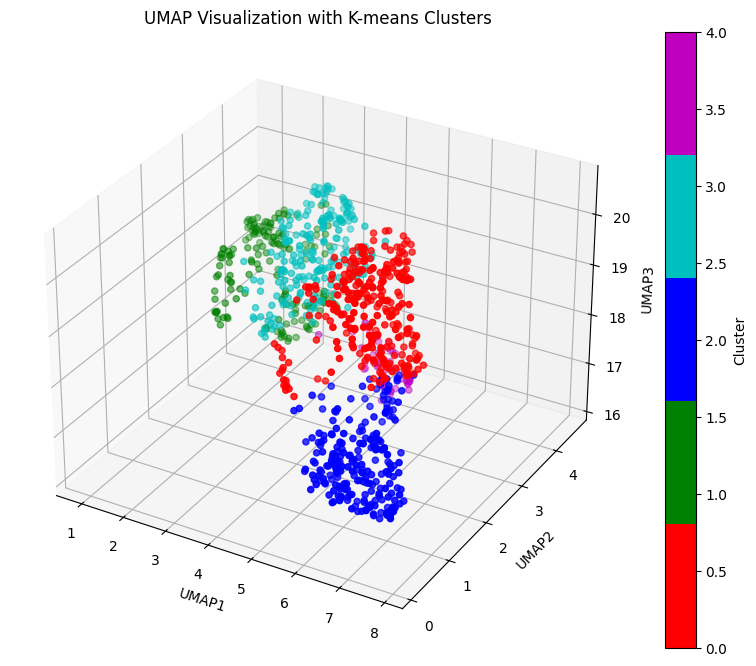

    Cluster  Next_Year_PosRank  Count  Total_Count  Percentage
0         0                 10     15          169           8
1         0                 20     30          168          17
2         0                 30     49          131          37
3         0                 40     41          123          33
4         0                 50    136          350          38
5         1                 10     85          169          50
6         1                 20     49          168          29
7         1                 30     21          131          16
8         1                 40     11          123           8
9         1                 50      4          350           1
10        2                 10     10          169           5
11        2                 20      6          168           3
12        2                 30     16          131          12
13        2                 40     38          123          30
14        2                 50    166          350     

In [12]:
UMAP_Vis(Passing)

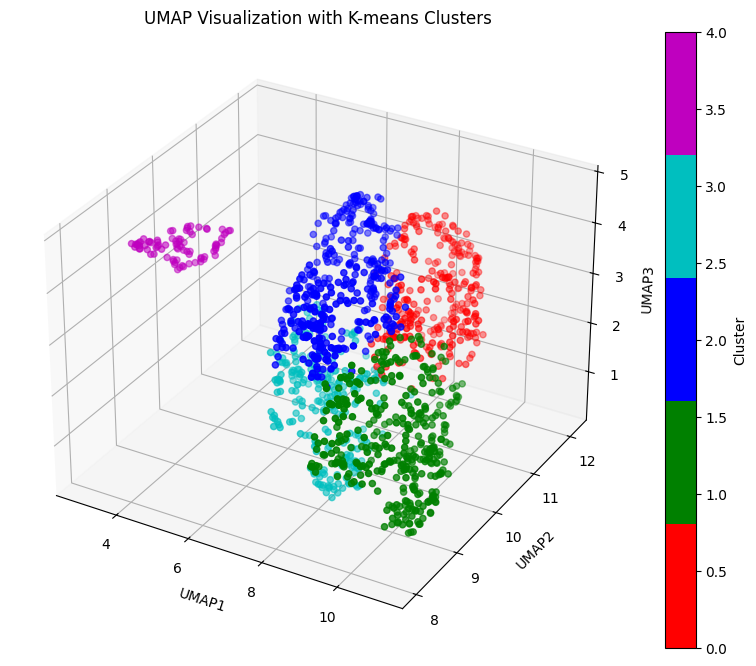

    Cluster  Next_Year_PosRank  Count  Total_Count  Percentage
0         0                 10      8          132           6
1         0                 20      9          112           8
2         0                 30     15          113          13
3         0                 40     23          118          19
4         0                 50    219          854          25
5         1                 10     14          132          10
6         1                 20     16          112          14
7         1                 30     25          113          22
8         1                 40     30          118          25
9         1                 50    272          854          31
10        2                 10     19          132          14
11        2                 20     25          112          22
12        2                 30     31          113          27
13        2                 40     30          118          25
14        2                 50    254          854     

In [13]:
UMAP_Vis(Rushing)

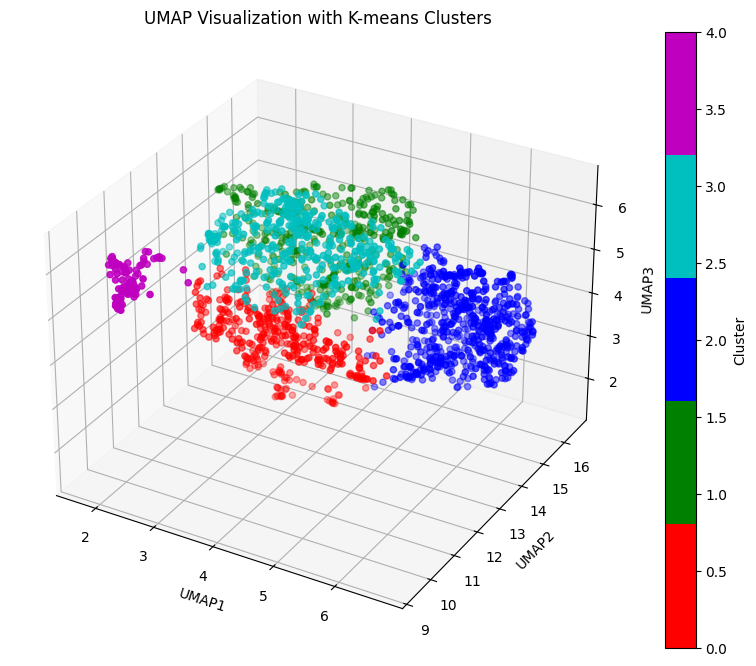

    Cluster  Next_Year_PosRank  Count  Total_Count  Percentage
0         0                 10     96          133          72
1         0                 20     65          124          52
2         0                 30     43          124          34
3         0                 40     36          116          31
4         0                 50    117         1341           8
5         1                 10      6          133           4
6         1                 20     21          124          16
7         1                 30     31          124          25
8         1                 40     24          116          20
9         1                 50    314         1341          23
10        2                 10     21          133          15
11        2                 20     25          124          20
12        2                 30     39          124          31
13        2                 40     30          116          25
14        2                 50    484         1341     

In [14]:
UMAP_Vis(Receiving)

We were not fully satisfied with the sihlouette scores that were produced by the UMAP + K-means algorithm, so we decided to decrease the complexity of the data by limiting the amount of columns.

In [15]:
def UMAP_Vis_reduced(df, cols, k):
    # UMAP
    columns_for_umap = cols

    data_for_umap = df[columns_for_umap]

    scaler = StandardScaler()
    data_for_umap_scaled = scaler.fit_transform(data_for_umap)

    umap_result = umap.UMAP(n_neighbors = 20, n_components=3, random_state=35, n_jobs=1).fit_transform(data_for_umap_scaled)

    umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])

    umap_df[['Player', 'Year']] = df[['Player', 'Year']]

    umap_df['Tm'] = df['Tm']
                       
    umap_df['Next_Year_PosRank'] = df['Next_Year_PosRank']

    # Fit K-means clustering model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(umap_result)

    cluster_labels = kmeans.predict(umap_result)

    cluster_cmap = ListedColormap(['r', 'g', 'b', 'c', 'm'])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], umap_df['UMAP3'], c=cluster_labels, cmap=cluster_cmap, marker='o')

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')
    ax.set_title('UMAP Visualization with K-means Clusters')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster')

    plt.show()
    
    # Concatenate cluster labels with Next_Year_PosRank
    umap_df['Cluster'] = cluster_labels

    # Group data by Cluster and Next_Year_PosRank, and count occurrences
    cluster_info = umap_df.groupby(['Cluster', 'Next_Year_PosRank']).size().reset_index(name='Count')

    cluster_info["Total_Count"] = 0
    cluster_info["Percentage"] = 0
    for rank in range(9):
        rank += 1
        rank *= 10

        total = cluster_info[cluster_info["Next_Year_PosRank"] == rank]["Count"].sum()

        cluster_info.loc[cluster_info["Next_Year_PosRank"] == rank, ["Total_Count"]] = total

        for cluster in range(max(cluster_info["Cluster"]) + 1):
            count = cluster_info[(cluster_info["Next_Year_PosRank"] == rank) & (cluster_info["Cluster"] == cluster)]["Count"]
            percent_val = pd.Int64Dtype().type(100 * count / total)
            cluster_info.loc[(cluster_info["Next_Year_PosRank"] == rank) & (cluster_info["Cluster"] == cluster), ["Percentage"]] = percent_val
            
    print(cluster_info)
    
    silhouette_avg = silhouette_score(data_for_umap, cluster_labels)
    print("Silhouette Score:", silhouette_avg)


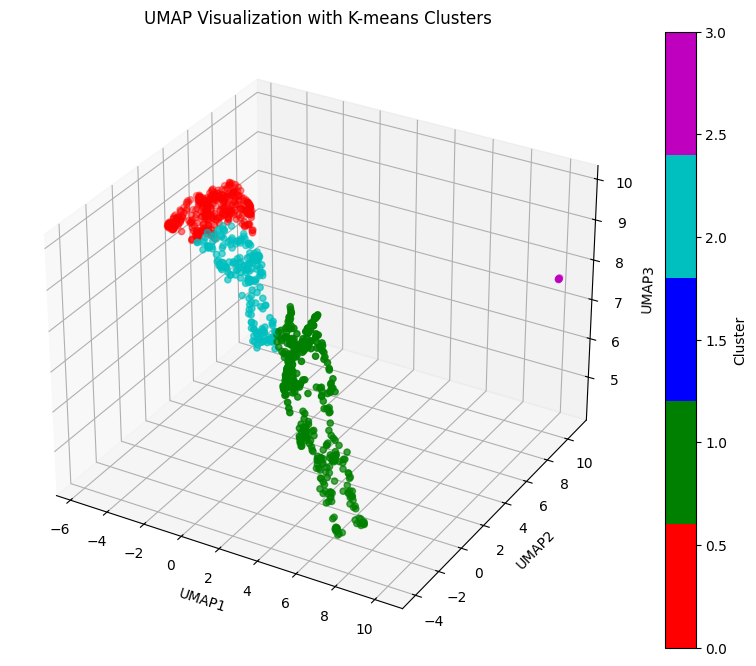

    Cluster  Next_Year_PosRank  Count  Total_Count  Percentage
0         0                 10    136          169          80
1         0                 20    118          168          70
2         0                 30     59          131          45
3         0                 40     31          123          25
4         0                 50     23          350           6
5         1                 10     12          169           7
6         1                 20     16          168           9
7         1                 30     29          131          22
8         1                 40     47          123          38
9         1                 50    254          350          72
10        2                 10     21          169          12
11        2                 20     33          168          19
12        2                 30     43          131          32
13        2                 40     44          123          35
14        2                 50     66          350     

In [16]:
UMAP_Vis_reduced(Passing, ['Cmp', 'Att','Cmp%','Yds','TD','Int','Y/A'], 4)

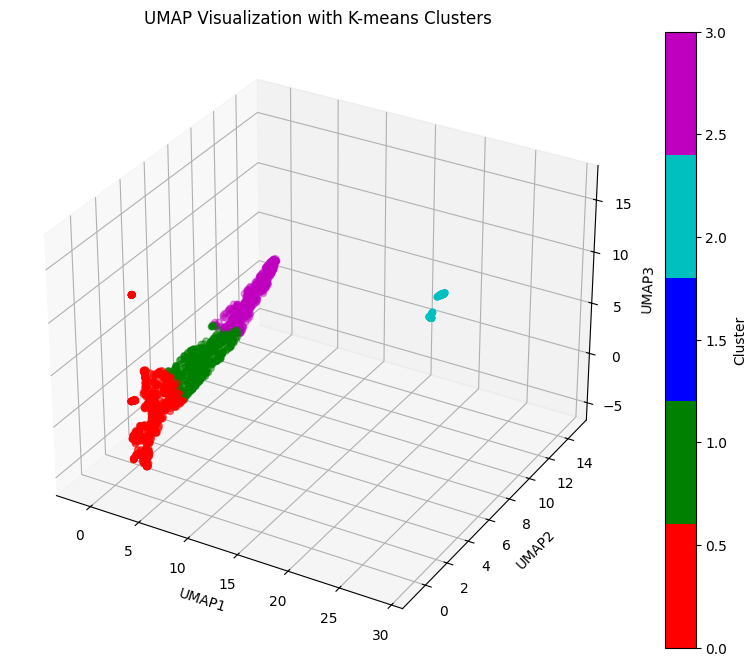

    Cluster  Next_Year_PosRank  Count  Total_Count  Percentage
0         0                 10      5          133           3
1         0                 20      6          124           4
2         0                 30     10          124           8
3         0                 40     12          116          10
4         0                 50    581         1341          43
5         1                 10     19          133          14
6         1                 20     21          124          16
7         1                 30     44          124          35
8         1                 40     41          116          35
9         1                 50    485         1341          36
10        2                 40      1          116           0
11        2                 50     65         1341           4
12        3                 10    109          133          81
13        3                 20     97          124          78
14        3                 30     70          124     

In [17]:
UMAP_Vis_reduced(Receiving, ['Tgt','Rec','Yds','TD','Succ%','R/G','Y/G'],4)

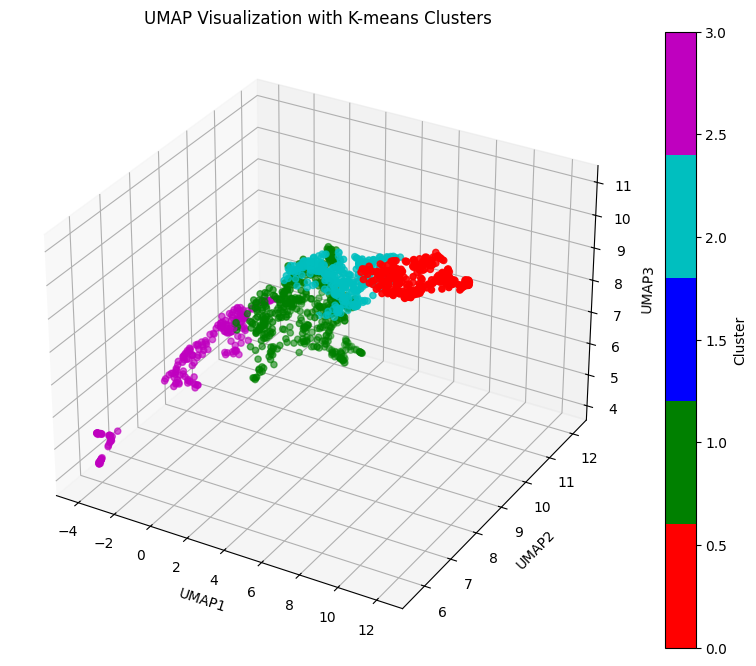

    Cluster  Next_Year_PosRank  Count  Total_Count  Percentage
0         0                 10     83          132          62
1         0                 20     63          112          56
2         0                 30     40          113          35
3         0                 40     35          118          29
4         0                 50     66          854           7
5         1                 10     11          132           8
6         1                 20     21          112          18
7         1                 30     26          113          23
8         1                 40     33          118          27
9         1                 50    402          854          47
10        2                 10     36          132          27
11        2                 20     27          112          24
12        2                 30     45          113          39
13        2                 40     41          118          34
14        2                 50    184          854     

In [18]:
UMAP_Vis_reduced(Rushing, ['Att','Yds','TD','1D','Succ%','Y/A','Y/G'],4)

### Evaluating our UMAP + K-Means Model: Silhouette Score

Here are the resulting Silhouette scores for our UMAP + K-means model.

In [1]:
print("Passing Silhouette Score:", 0.3176)

print("Receiving Silhouette Score:", 0.3369)

print("Rushing Silhouette Score:", 0.2751)

Passing Silhouette Score: 0.3176
Receiving Silhouette Score: 0.3369
Rushing Silhouette Score: 0.2751


# Discussion

### Interpreting the result

After organizing our data and making it interprable for K-Means, we ran a few tests on the passing, rushing, and receiving data frames to see if there was any obvious clustering. After going over the algorithm a few times, we found that the silhouette score always seemed to be low. We thought it best to keep the complexity low and only involve a few parameters that we thought would be most crucial. After implementing that, we found that our silhouette scores soared towards the 0.3 range of values.

Wanting to cover more of the data, we decided to involve all of the columns again but use dimension reduction techniques to expand on local differences in the data. Using UMAP, we reduced the dimensions of each data frame into a 3-dimensional graph. After applying K-means to those graphs we found that the silhouette scores were still worse than the K-Means with the few columns.

In an effort to visualize the data and gain a higher silhouette score, we again applied UMAP to our data frames but only used the columns that we used in the first K-Means operation. This resulted in similar results to the first K-Means but they were slightly increased. 

The UMAP also allowed us to see the special relationship between different clusters. We also printed out a table with each UMAP to see the percentages of each group in the clusters. Clusters with large amounts of Next_Year_PosRank 10 also had a large amount of Next_Year_PosRank 20. This behavior was a pattern with all values of the Next_Year_PosRank in all of the K-Mean Graphs. This showed us that the difference in performance that we were looking for came from players who had very similar attributes/stats. Even though there was mingling between the different clusters, there seemed to be a difference in the extremes. For example, clusters with large groups of Next_Year_PosRank 10 had a low percentage of Next_Year_PosRank 40 and Next_Year_PosRank 50.

While the algorithm itself did not fully satisfy the initial goals we had for this project, we were still able to extract important information that could still be useful to those looking for ideal fantasy draft picks. The algorithm ended up being a lot more broad than what we hoped for. For example, instead of a cluster showing the top 10 players, it displayed more broadly into the top 20 players. The algorithm wasn’t able to pick up the difference between those ranking at least 10 positions away from them, it ended up being closer to 20. 


### Limitations

While running through the various measures and ways to model our data and seek after the best way to measure how well these football players do, we ran into a number of limitations based on the data. 

Some initial limitations given our dataset was the variety of football players and what kind of performance measures they excel at. This is because the data has a variety of positions and players that overlap. Some of the players passed and rushed and received, as football isn’t necessarily constrained completely from role to role. However, we got over this limitation by just limiting players to their role -- for example Quarterbacks are focused entirely on Passing, Running Backs on Rushing, and Wide Receivers on Receiving. However, because we limited the players to their respective positions, we don’t necessarily get the full picture of everything that is going on. 

In addition, some limitations to our goal of helping out a fantasy football draft is that we don’t have data on more recent players or rookies that come into the new year. Instead, we are basing everything off of previous seasons with confounding variables - like injuries, sicknesses, retirement, or even being traded to different teams -- as a different team dynamic can lead to varying levels of performance. Thus, our models are limited in the sense that we cannot take into account all the variables in the real world that could heavily influence or change how well players would do the next season. 

Another big limitation in analyzing our models was the lack of Truth labels. This is because we don’t necessarily have data that can place the players into certain categories of truth, where each cluster from K-Mean neatly aligns with how a player performs the next year. In our initial proposal for this project, we had wanted to calculate the Adjusted Rand Score, a score that measures the similarities between clusterings. However, because we don’t have any ground Truth Labels, we couldn’t calculate the Adjusted Rand Score, and instead we had to seek for other evaluation metrics that fit our data. 

Finally, some other limitations that we were running into were model limitations, in how the models could best capture our data. We tried many different models and also tried Dim-Reducing our data, but it seemed like none of the models really could cluster our data very well. For example, we tried Gaussian Mixture Models, but the clustering ended up being even worse than K-Means. Furthermore, we ended up trying U-Map then K-Means, but the clustering still didn’t work very well, and we experimented with various cluster amounts and tried changing around our `n_neighbors` number as well. The silhouette scores that we were receiving were less than satisfactory, and we played around with the amount of clusters, decreasing the amount and getting a higher silhouette score. We were looking for a good balance between a good amount of clusters and high compatibility with the clusters. We tried compromising, but in the end, we struggled with finding the ideal hyperparameters for our models and dataset. 

  

### Ethics & Privacy

- The data files that our group used are publicly available on Kaggle and Pro Football Reference, which are publicly accessible sites.
- The players’ information and contracts are also available publicly online. Their contracts cannot be kept private due to the league to enforce salary cap requirements. 
- The potential bias that may have occurred when collecting the data:
    - Players who have fame or recognition are typically expected to maintain a high level of proficiency.
    - Players who newly joined the league typically characterized by lower salaries, also often viewed as still developing their skills.
    - Players with high salaries are expected to justify their compensation through high quality on-field contributions.

### Conclusion

Our football analysis utilizes algorithms such as UMAP and K-Means to model different biological features and performance statistics of players in the NFL. Although there are a couple limitations, potential fantasy players can look at our model and determine their most ideal draft picks. We created a variable called Next_Year_PosRank, which would predict which ranking each player would be at during next year’s football season. 

People who are looking to use our algorithm to determine their ideal fantasy picks can input the statistics of a player, and our algorithm will then show which cluster they belong to. This cluster would predict players' rankings in the upcoming season of fantasy football. These clusters turned out to be very generalized and did not get as specific as we wanted them to be. Instead, the results of our algorithm will broadly display where a player might rank with a margin of around 10 positions.

Even outside of using the algorithm for fantasy football, it could also be applied to other forms of sports betting. If we were to continue on with this project, we could potentially include more feature engineering, such as using forward selection to determine the most optimal set of features rather than hand-selecting it like we did. 

# Footnotes
<a name="operationnote"></a>1.[^](#operation): *Super Bowl LVIII is most-watched telecast in history: NFL Football Operations.* Super Bowl LVIII is Most-Watched Telecast in History | NFL Football Operations. (2024a, February 13). https://operations.nfl.com/updates/the-game/super-bowl-lviii-is-most-watched-telecast-in-history/<br> 
<a name="NFLAInote"></a>2.[^](#NFLAI): *NFL Artificial Intelligence, Analytics, & Statistics.* Gridiron AI. (n.d.). https://gridironai.com/football/<br> 
<a name="Cantalupa"></a>3.[^](#Cantalupa): Cantalupa, N. (2024, January 17). *NFL team data 2003-2023.* Kaggle. https://www.kaggle.com/datasets/nickcantalupa/nfl-team-data-2003-2023<br>
<a name="Steussienote"></a>4.[^](#Steussie): Steussie, T. (2020, April 27). *NFL play Statistics Dataset (primary).* Kaggle. https://www.kaggle.com/datasets/toddsteussie/nfl-play-statistics-dataset-2004-to-present?select=combine.csv<br> 
<a name="profootballnote"></a>5.[^](#profootball): *Pro Football Reference.* Pro. (n.d.). https://www.pro-football-reference.com/<br> 